# ForrestGump电影基本信息

* 构建了阿甘正传平均情绪评分-电影-fMRI的对齐

* 根据俊行师兄之前处理HCP的电影的代码修改而来

* 时间序列：15人subjects: subjects_Gump； ts_arr：time-series shape = (15, 285, 3543)


In [1]:
import os
import numpy as np
from sklearn.preprocessing import scale  # Import the scale function for normalizing data
from sklearn.decomposition import PCA  # Import PCA for dimensionality reduction
from umap import UMAP  # Import UMAP for non-linear dimensionality reduction
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
import ffmpeg
import joblib


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as anim  # 改变导入名称
from matplotlib.animation import PillowWriter
from matplotlib.colors import to_rgb
import cv2
import pandas as pd

In [2]:
cd '/share/user_data/public/experiment/emofMRI/ForrestGump/movie_display'

/share/user_data/public/experiment/emofMRI/ForrestGump/movie_display


In [3]:
def play_movie_at_time(movie_file, start_time):
    return HTML(f"""
    <video width="640" height="480" controls onloadedmetadata="this.currentTime={start_time}">
        <source src="../movie_stimulus/{movie_file}" type="video/mp4">
    </video>
    """)

In [4]:
def play_movie_segment(movie_file, start_time, end_time):
    """
    播放指定时间段的视频片段
    
    参数:
    movie_file: 视频文件名
    start_time: 开始时间（秒）
    end_time: 结束时间（秒）
    """
    duration = end_time - start_time
    
    return HTML(f"""
    <video width="640" height="480" controls 
           onloadedmetadata="this.currentTime={start_time}"
           ontimeupdate="if(this.currentTime >= {end_time}) this.pause()">
        <source src="../Movie_stimulus/{movie_file}" type="video/mp4">
    </video>
    """)

In [5]:
def g_id_list():
    id_list = os.listdir('/share/user_data/public/experiment/emofMRI/ForrestGump/time_series_delete')
    id_intersec = []
    movie_name_ls = ['run-1','run-2','run-3','run-4','run-5','run-6','run-7','run-8']
    
    for sub in id_list:
        # 判断是否存在的标签
        flag = []
        for mov_i in movie_name_ls:
            flag.append(os.path.exists(os.path.join('/share/user_data/public/experiment/emofMRI/ForrestGump/time_series_delete',sub,'ses-movie','func',
                                                    sub+'_'+'ses-movie_task-movie_'+mov_i+'_space-MNI152NLin6Asym_desc-preproc_bold_preprocess-fmriprep_gs_filter_cropped.npy')))
        if np.sum(flag) == 8:
            id_intersec.append(sub)
    return id_intersec

# 导入电影时间序列，是否平移
def ts_movie_long():
    id_intersec = g_id_list()
    movie_name_ls = ['run-1','run-2','run-3','run-4','run-5','run-6','run-7','run-8']
    
    sub_ts_ls = []
    for movie_name_i in movie_name_ls:
        movie_i_ts_ls = []
        for sub in id_intersec:
            movie_i_ts_ls.append(np.load(os.path.join('/share/user_data/public/experiment/emofMRI/ForrestGump/time_series_delete',sub,'ses-movie','func',
                                                    sub+'_'+'ses-movie_task-movie_'+movie_name_i+'_space-MNI152NLin6Asym_desc-preproc_bold_preprocess-fmriprep_gs_filter_cropped.npy')).T)
        movie_i_ts_ls = np.array(movie_i_ts_ls)
        print(f'ts shape:{movie_i_ts_ls.shape}')
        sub_ts_ls.append(movie_i_ts_ls)
    
    return sub_ts_ls

def calculate_average_distance(matrix):
    """
    计算给定矩阵的点到中心点的距离平均值。

    参数:
    matrix (numpy.ndarray): 形状为(170, 3)的矩阵。

    返回值:
    float: 点到中心点的距离平均值。
    """
    # 计算中心点
    center = np.mean(matrix, axis=0)
    
    # 计算每个点到中心点的距离
    distances = np.linalg.norm(matrix - center, axis=1)
    
    # 计算平均距离
    average_distance = np.mean(distances)
    
    return average_distance

def smooth_array_1d(array, window_size=10):
    if array.ndim != 1:
        raise ValueError("Input array must be 1-dimensional")
    
    num_timepoints = array.shape[0]
    half_window = window_size // 2
    
    if num_timepoints < window_size:
        raise ValueError("Window size must be less than the number of time points in the array")
    
    # Initialize the smoothed array
    smoothed_array = np.zeros(num_timepoints)
    
    for i in range(num_timepoints):
        if i - half_window < 0:
            start_idx = 0
            end_idx = window_size

        elif i + half_window + 1 > num_timepoints:
            start_idx = i - window_size
            end_idx = num_timepoints

        else:
        
            start_idx =i - half_window
            end_idx = i + half_window + 1
        smoothed_array[i] = np.mean(array[start_idx:end_idx])
    
    return smoothed_array


def get_movie_info_with_text(index):
    # 定义每个片段的长度
    segment_lengths = [446, 200, 233, 196, 234, 317, 163, 398, 56, 361, 70, 58, 476,335]
    
    # 电影片段的起始时间点
    movie_segments = {
        0: {'movie': 'forrest_01.mp4', 'start': 0, 'name': 'run1'},
        1: {'movie': 'forrest_02.mp4', 'start': 3, 'name': 'run2-1'},
        2: {'movie': 'forrest_02.mp4', 'start': 203, 'name': 'run2-2'},
        3: {'movie': 'forrest_03.mp4', 'start': 3, 'name': 'run3-1'},
        4: {'movie': 'forrest_03.mp4', 'start': 199, 'name': 'run3-2'},
        5: {'movie': 'forrest_04.mp4', 'start': 3, 'name': 'run4-1'},
        6: {'movie': 'forrest_04.mp4', 'start': 320, 'name': 'run4-2'},
        7: {'movie': 'forrest_05.mp4', 'start': 3, 'name': 'run5-1'},
        8: {'movie': 'forrest_05.mp4', 'start': 401, 'name': 'run5-2'},
        9: {'movie': 'forrest_06.mp4', 'start': 3, 'name': 'run6-1'},
        10: {'movie': 'forrest_06.mp4', 'start': 364, 'name': 'run6-2'},
        11: {'movie': 'forrest_07.mp4', 'start': 3, 'name': 'run7-1'},
        12: {'movie': 'forrest_07.mp4', 'start': 61, 'name': 'run7-2'},
        13: {'movie': 'forrest_08.mp4', 'start': 3, 'name': 'run8'}
     }
        
    # 计算累积长度
    cumulative_lengths = np.cumsum([0] + segment_lengths)
    
    # 找到对应的片段
    for i in range(len(segment_lengths)):
        if cumulative_lengths[i] <= index < cumulative_lengths[i+1]:
            relative_index = index - cumulative_lengths[i]
            segment_info = movie_segments[list(movie_segments.keys())[i]]
            
            # 计算具体时间点
            actual_time = segment_info['start']*2 + relative_index*2
            minutes = actual_time // 60
            seconds = actual_time % 60
            
            # 打印电影信息
            print(f"\n电影信息：")
            print(f"{segment_info['movie']} {segment_info['name']} {minutes:02d}:{seconds:02d}")

            emotion_data = pd.read_csv('/share/user_data/public/experiment/emofMRI/ForrestGump/emotion_rating_process/ratings_mean_delete.csv')

            print(f"\n情绪评分：")
            print(f"Happiness: {emotion_data.iloc[index,1]:.3f}")
            print(f"Surprise: {emotion_data.iloc[index,2]:.3f}")
            print(f"Fear: {emotion_data.iloc[index,3]:.3f}")
            print(f"Sadness: {emotion_data.iloc[index,4]:.3f}")
            print(f"Anger: {emotion_data.iloc[index,5]:.3f}")
            print(f"Disgust: {emotion_data.iloc[index,6]:.3f}")

            return segment_info['movie'], actual_time



def plot_with_segments(data,title):
    # 设置图表尺寸
    plt.figure(figsize=(20, 4))
    
    # 绘制主数据线
    plt.plot(data)
    
    # 计算片段分界点
    segments = [
        446,           # run-1
        200, 233,     # run-2 
        196, 234,     # run-3
        317, 163,     # run-4
        398, 56,      # run-5
        361, 70,      # run-6
        58, 476,      # run-7
        335           # run-8
    ]
    movie_name = ['run1','run2-1','run2-2','run3-1','run3-2','run4-1','run4-2','run5-1','run5-2','run6-1','run6-2','run7-1','run7-2','run8']
    
    boundaries = np.cumsum(segments)
    
    # 添加垂直分界线和标签
    for i, x_pos in enumerate(boundaries):
        plt.axvline(x=x_pos, color='r', linestyle='--', alpha=0.3)
        plt.text(x_pos, plt.ylim()[0], movie_name[i], rotation=45, ha='right')
    
    # 设置x轴刻度
    x_ticks = np.arange(0, len(data), 100)
    plt.xticks(x_ticks, rotation=45)
    
    # 添加网格
    plt.grid(True, alpha=0.3)
    
    # 添加标题和标签
    plt.title(title)
    plt.xlabel('TR')
    plt.ylabel('synchronization(-zscore)')
    
    # 调整布局
    plt.tight_layout()
    
    return plt.show()

In [6]:
subjects_gump = g_id_list()
gump_15clips_ts = ts_movie_long()

ts shape:(15, 285, 446)
ts shape:(15, 285, 433)
ts shape:(15, 285, 430)
ts shape:(15, 285, 480)
ts shape:(15, 285, 454)
ts shape:(15, 285, 431)
ts shape:(15, 285, 534)
ts shape:(15, 285, 335)


### 对时间序列进行标准化
##### 每个run下不同被试分别标准化，最后再拼到一起

In [7]:
## 对每个被试分别标准化每个clip
n_subs = gump_15clips_ts[0].shape[0]

ts_norm = []  # Initialize an empty list to store normalized time-series
for ts_i in gump_15clips_ts:
    # Scale each subject's time-series data along the ROI axis
    ts_i_norm = [scale(ts_i[i], axis=1) for i in range(n_subs)]
    ts_norm.append(np.array(ts_i_norm))  # Append the normalized data for each clip/movie
# Select indices of movies/clips longer than 2 minutes and concatenate their time-series data
ts_arr = np.dstack([ts_i for ts_i in ts_norm])  # Stack the selected clips along a new axis

/localdata/software/anaconda3/envs/wzy_python/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/localdata/software/anaconda3/envs/wzy_python/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/localdata/software/anaconda3/envs/wzy_python/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/localdata/software/anaconda3/envs/wzy_python/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:265: Us

In [8]:
ts_arr.shape

(15, 285, 3543)

In [9]:
# print('time-series shape =',ts_arr.shape)  # Print the shape of the concatenated time-series data
# nTR = ts_arr.shape[2]
# joblib.dump(ts_arr, os.path.join('./HMM', 'timeseries_data.joblib'))

### 低维空间映射

* 沿着（subjects * ts, ROI）降维到（subjects * ts, 3）

In [10]:
## 对每个被试分别标准化整部电影
scale_axis=1
ts_norm = np.array([scale(ts_arr[i], axis=scale_axis) for i in range(n_subs)])


In [11]:
ts_stack = np.vstack([ts_norm[i].T for i in range(n_subs)])
ts_stack.shape 

(53145, 285)

In [12]:
# Select a filter (here, we use UMAP)
umap_model = UMAP(n_components=3,n_neighbors=25,random_state=42,min_dist=0.01,metric='euclidean')
pca = PCA(n_components=umap_model.n_components, random_state=42)

In [13]:
## 利用列表推导式，15*3543，285 做完umap后再转成15，3543，285
nTR = ts_arr.shape[2]
pca_res = pca.fit_transform(ts_stack)
umap_model.init = pca_res
embeds = umap_model.fit_transform(ts_stack)  # Fit and transform the test data using UMAP
sub_embeds = np.array([embeds[i*nTR:(i+1)*nTR] for i in range(n_subs)])
np.save('sub_embeds.npy', sub_embeds)

# hcp_umap = np.load('sub_embeds.npy')

/localdata/software/anaconda3/envs/wzy_python/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [14]:
embeds.shape

(53145, 3)

In [15]:
sub_embeds.shape

(15, 3543, 3)

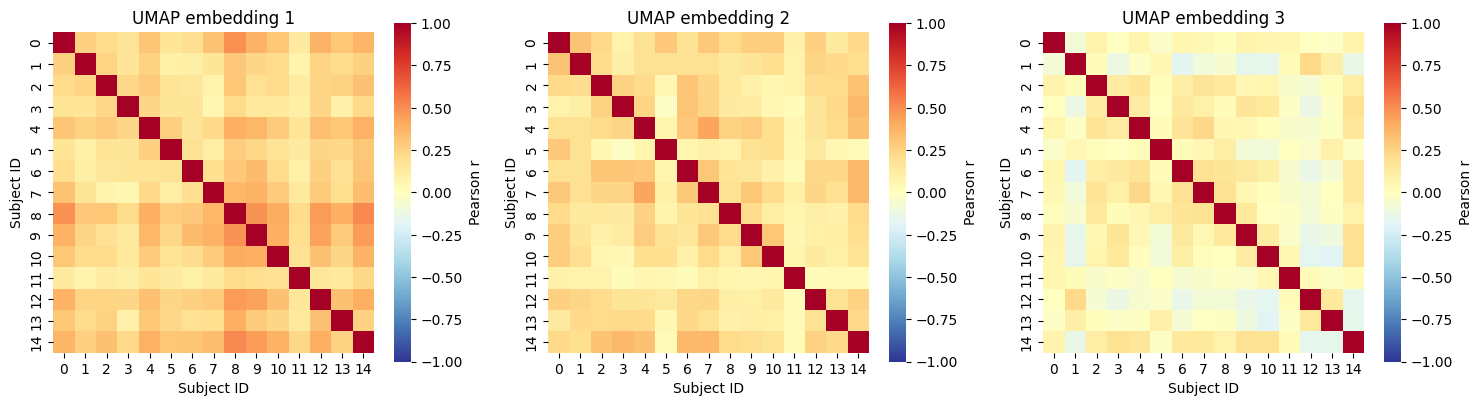

In [16]:

from scipy.stats import pearsonr

# sub_embeds shape: (15, 3543, 3)
# 15个被试，3543个时间点，3个UMAP维度

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for dim in range(3):
    # 创建15x15相关矩阵
    corr_matrix = np.zeros((15, 15))
    
    # 计算被试间时间序列相关性
    for i in range(15):
        for j in range(15):
            # 提取被试i和被试j在维度dim上的时间序列
            ts_i = sub_embeds[i, :, dim]  # shape: (3543,)
            ts_j = sub_embeds[j, :, dim]  # shape: (3543,)
            
            # 计算皮尔逊相关系数
            r, _ = pearsonr(ts_i, ts_j)
            corr_matrix[i, j] = r
    
    # 绘制热图
    sns.heatmap(corr_matrix, 
                ax=axes[dim],
                annot=False, 
                cmap='RdYlBu_r', 
                vmin=-1, 
                vmax=1, 
                square=True,
                cbar_kws={'label': 'Pearson r'})
    
    axes[dim].set_title(f'UMAP embedding {dim+1}')
    axes[dim].set_xlabel('Subject ID')
    axes[dim].set_ylabel('Subject ID')

plt.tight_layout()
plt.show()

### 计算每个时刻UMAP的个体间距离
* 取负数这样越大，代表个体间越相近

In [17]:
movie_ind = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
Mov_length = {
   0: 446,1: 200,2: 233,3: 196,4: 234,5: 317,
   6: 163,7: 398,8: 56,9: 361,10: 70,11: 58,12: 476,13: 335}

## 按照umap成分做zscore
gump_umap_z = stats.zscore(sub_embeds, axis=2)
gump_umap_z_smooth = np.zeros_like(gump_umap_z)

# 电影的umap进行一定的平滑
for i in range(15):
    c = 0
    for j in movie_ind:
        len_ = Mov_length[j]
        gump_umap_z_smooth[i, c:c+len_, 0] = smooth_array_1d(gump_umap_z[i, c:c+len_, 0], window_size=20)
        gump_umap_z_smooth[i, c:c+len_, 1] = smooth_array_1d(gump_umap_z[i, c:c+len_, 1], window_size=20)
        gump_umap_z_smooth[i, c:c+len_, 2] = smooth_array_1d(gump_umap_z[i, c:c+len_, 2], window_size=20)
        c+=len_


distance_all = np.zeros(3543)
for i in range(3543):
    distance_all[i] = calculate_average_distance(gump_umap_z_smooth[:, i, :])

## 欧几里得距离标准化后的负数，这样值越大表示同步性越高
distance_all_z = -1*stats.zscore(distance_all)

In [18]:
gump_umap_z_smooth[:, i, :].shape

(15, 3)

In [19]:
np.save('distance_all_z.npy', distance_all_z)

In [20]:
## 原始时间序列尺度
distance_all_ts = np.zeros(3543)
for i in range(3543):
    distance_all_ts[i] = calculate_average_distance(ts_arr[:, :, i])

distance_all_ts_z = -1*stats.zscore(distance_all_ts)

### 可视化

In [21]:
distance_all_z.shape

(3543,)

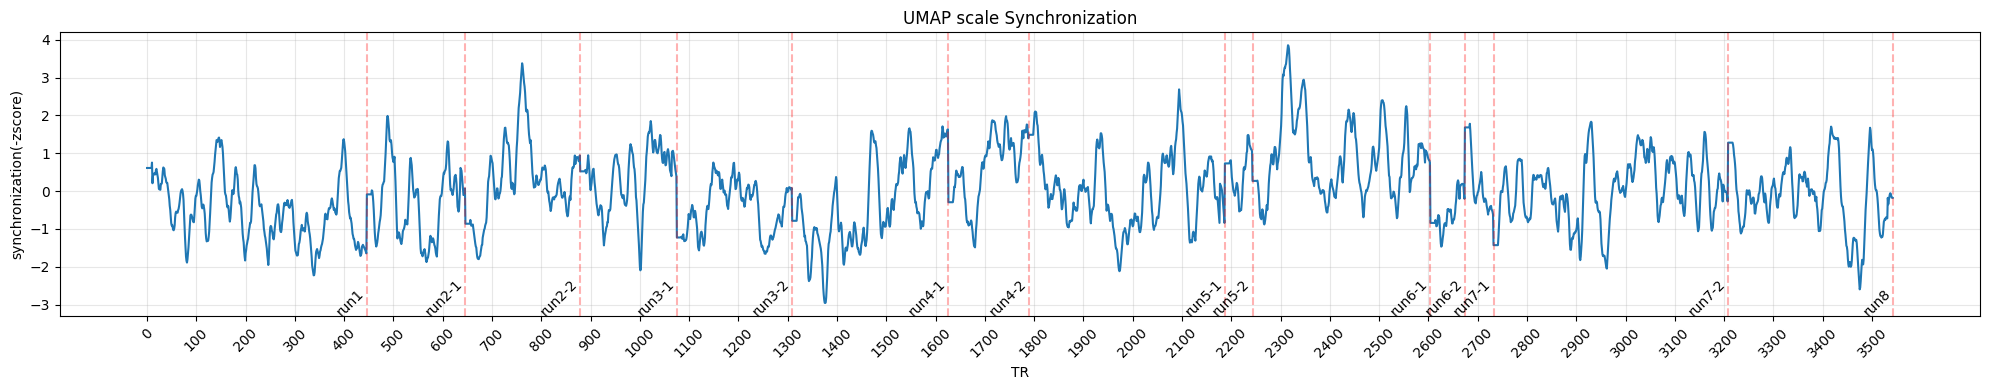

In [22]:
plot_with_segments(distance_all_z,title = 'UMAP scale Synchronization')

In [24]:
movie_file, time_point = get_movie_info_with_text(3543) 
play_movie_at_time(movie_file, time_point)

TypeError: cannot unpack non-iterable NoneType object